In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from scipy.ndimage import gaussian_filter
import copy
import seaborn as sns
# from sklearn.neighbors import KernelDensity
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import shapely.geometry as sgeom
import colorcet as cc
import warnings
%matplotlib inline

In [2]:
# PHASE = 'Summer'
PHASE = 'Winter'

env_varname = 'intqv'

# PF land fraction threshold to separate land vs. ocean MCS
land_frac_thresh = 0.7
ocean_frac_thresh = 0.1

if PHASE == 'Summer':
    track_period = '20160801_20160910'
    block_times = pd.to_datetime(['2016-08-01T00', '2016-08-10T00'])
    lon_bounds = [-180, 180]
    lat_bounds = [-15, 30]
if PHASE == 'Winter':
    track_period = '20200120_20200301'
    block_times = pd.to_datetime(['2020-01-20T00', '2020-02-01T00'])
    lon_bounds = [-180, 180]
    lat_bounds = [-20, 15]

rootdir = f'/pscratch/sd/f/feng045/DYAMOND/{PHASE}/'

if PHASE == 'Summer':
    name_map = {
        'obs': 'OBS',
        'm1': 'ARPEGE',
        'm2': 'IFS',
        'm3': 'MPAS',
        'm4': 'NICAM',
        'm5': 'SAM',
        'm6': 'UM',
        'm7': 'FV3',
        # 'm8': 'ICON',
    }

if PHASE == 'Winter':
    name_map = {
        'obs': 'OBS',
        'm1': 'ARPEGE',
        'm2': 'IFS',
        # 'm3': 'MPAS',
        # 'm4': 'NICAM',
        'm5': 'SAM',
        'm6': 'UM',
        'm7': 'GRIST',
        # 'm8': 'SCREAM',
        'm9': 'XSHiELD',
        'm10': 'GEOS',
        # 'm11': 'ICON',
    }

# Environmental files
envfiles_map = {key:f'{rootdir}{value}/envs/{PHASE}_{value}_{env_varname}_map.nc' for key,value in name_map.items()}
# rainfiles_timeseries = {key:f'{rootdir}{value}/envs/{PHASE}_{value}_rain_timeseries.nc' for key,value in name_map.items()}
# rainfiles_timeseries = {key:f'{rootdir}{value}/stats/monthly/mcs_rain_timeseries_{track_period}.nc' for key,value in name_map.items()}

topfile = '/global/cfs/cdirs/m1867/zfeng/gpm/map_data/era5_orography.nc'

figdir = f'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/{PHASE}/figures/MCSMIP/'
os.makedirs(figdir, exist_ok=True)
print(figdir)

/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Winter/figures/MCSMIP/


# Check if input files exist

In [3]:
for key, value in envfiles_map.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/Winter/OBS/envs/Winter_OBS_intqv_map.nc: True
/pscratch/sd/f/feng045/DYAMOND/Winter/ARPEGE/envs/Winter_ARPEGE_intqv_map.nc: True
/pscratch/sd/f/feng045/DYAMOND/Winter/IFS/envs/Winter_IFS_intqv_map.nc: True
/pscratch/sd/f/feng045/DYAMOND/Winter/SAM/envs/Winter_SAM_intqv_map.nc: True
/pscratch/sd/f/feng045/DYAMOND/Winter/UM/envs/Winter_UM_intqv_map.nc: True
/pscratch/sd/f/feng045/DYAMOND/Winter/GRIST/envs/Winter_GRIST_intqv_map.nc: True
/pscratch/sd/f/feng045/DYAMOND/Winter/XSHiELD/envs/Winter_XSHiELD_intqv_map.nc: True
/pscratch/sd/f/feng045/DYAMOND/Winter/GEOS/envs/Winter_GEOS_intqv_map.nc: True


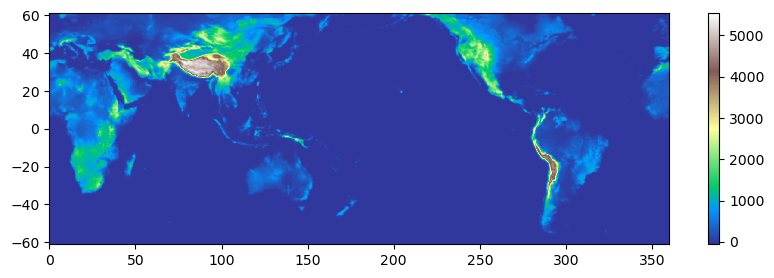

In [4]:
# Read topography data
dstop = xr.open_dataset(topfile)
# Convert surface geopotential to height in meters
ter = dstop.z.sel(latitude=slice(61,-61)).squeeze() / 9.80665
ter_s = gaussian_filter(ter, 1)
lon_ter = dstop.longitude
lat_ter = dstop.latitude.sel(latitude=slice(61,-61))

fig = plt.figure(figsize=[10,3], dpi=100)
plt.pcolormesh(lon_ter, lat_ter, ter_s, cmap='terrain')
plt.colorbar()

In [5]:
# Read OBS (ERA5) data
dso = xr.open_dataset(list(envfiles_map.values())[0])
# Convert lat from 0~360 to -180~+180
# lon_o = ((dso.lon - 180) % 360) - 180
lon_o = dso.lon
lat_o = dso.lat
dso['lon'] = lon_o
dso['lat'] = lat_o
# Add a source coordinate
dso = dso.assign_coords(source='obs')
dso

<xarray.Dataset>
Dimensions:  (lat: 479, lon: 1440)
Coordinates:
  * lat      (lat) float64 -59.75 -59.5 -59.25 -59.0 ... 59.0 59.25 59.5 59.75
  * lon      (lon) float64 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
    source   <U3 'obs'
Data variables:
    intqv    (lat, lon) float32 ...
Attributes:
    title:       Time mean intqv map
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    start_date:  2020-02-01T00
    end_date:    2020-03-01T00
    created_on:  Wed Feb 28 14:30:12 2024

In [6]:
# # Read OBS (ERA5) data
# # Roll lon=720 to make the data start from -180~+180
# dso = xr.open_dataset(list(envfiles_map.values())[0]).roll(lon=720, roll_coords=True)
# # Convert lat from 0~360 to -180~+180
# lon_o = ((dso.lon - 180) % 360) - 180
# lat_o = dso.lat
# dso['lon'] = lon_o
# dso['lat'] = lat_o
# # Add a source coordinate
# dso = dso.assign_coords(source='obs')
# dso

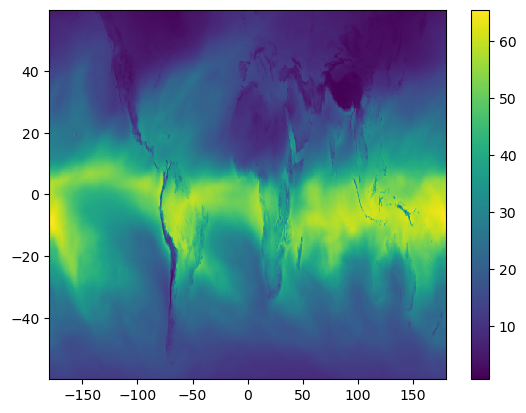

In [7]:
plt.pcolormesh(lon_o, lat_o, dso.intqv)
plt.colorbar()

In [8]:
# Read all model data in Xarray Dataset
dsm = xr.open_mfdataset(list(envfiles_map.values())[1:], concat_dim='source', combine='nested')
# Assign new coordinate 'source' using names
dsm['source'] = list(name_map.keys())[1:]
lon_m = dsm.lon
lat_m = dsm.lat
start_date = dsm.attrs['start_date']
end_date = dsm.attrs['end_date']
dsm

<xarray.Dataset>
Dimensions:  (source: 7, lat: 1200, lon: 3600)
Coordinates:
  * lat      (lat) float64 -59.95 -59.85 -59.75 -59.65 ... 59.75 59.85 59.95
  * lon      (lon) float64 -179.9 -179.8 -179.8 -179.6 ... 179.8 179.8 179.9
  * source   (source) <U3 'm1' 'm2' 'm5' 'm6' 'm7' 'm9' 'm10'
Data variables:
    intqv    (source, lat, lon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
Attributes:
    title:       Time mean intqv map
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    start_date:  2020-02-01T00
    end_date:    2020-03-01T00
    created_on:  Wed Feb 28 13:08:20 2024

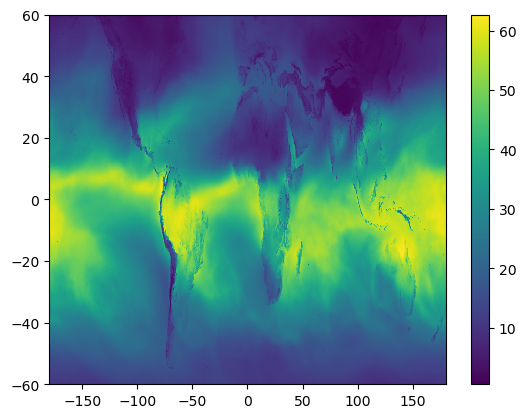

In [9]:
plt.pcolormesh(lon_m, lat_m, dsm.intqv.sel(source='m1'))
plt.colorbar()

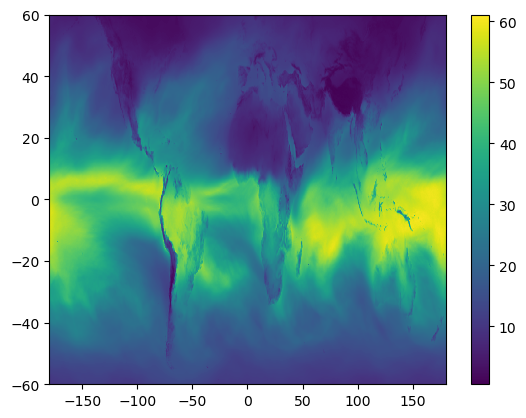

In [10]:
plt.pcolormesh(lon_m, lat_m, dsm.intqv.sel(source='m7'))
plt.colorbar()

In [11]:
# Interpolate OBS to model grid
dso_interp = dso.interp(lat=lat_m, lon=lon_m, method='linear')
dso_interp

<xarray.Dataset>
Dimensions:  (lat: 1200, lon: 3600)
Coordinates:
    source   <U3 'obs'
  * lat      (lat) float64 -59.95 -59.85 -59.75 -59.65 ... 59.75 59.85 59.95
  * lon      (lon) float64 -179.9 -179.8 -179.8 -179.6 ... 179.8 179.8 179.9
Data variables:
    intqv    (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    title:       Time mean intqv map
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    start_date:  2020-02-01T00
    end_date:    2020-03-01T00
    created_on:  Wed Feb 28 14:30:12 2024

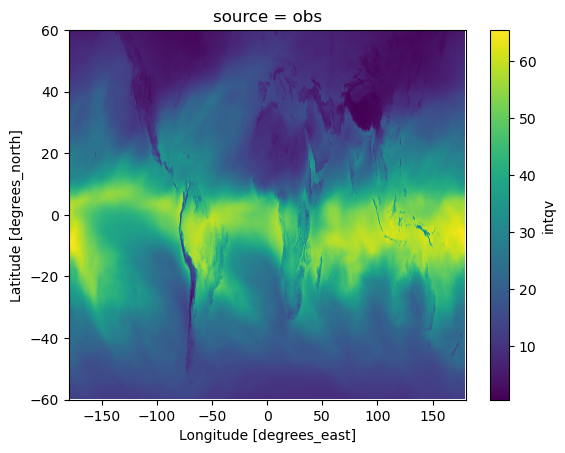

In [12]:
dso_interp.intqv.plot()

In [13]:
# Combine OBS & model DataArrays
intqv_combine = xr.concat([dso_interp.intqv, dsm.intqv], dim='source')
intqv_combine

<xarray.DataArray 'intqv' (lat: 1200, lon: 3600, source: 8)>
dask.array<concatenate, shape=(1200, 3600, 8), dtype=float64, chunksize=(1200, 3600, 1), chunktype=numpy.ndarray>
Coordinates:
  * source   (source) <U3 'obs' 'm1' 'm2' 'm5' 'm6' 'm7' 'm9' 'm10'
  * lat      (lat) float64 -59.95 -59.85 -59.75 -59.65 ... 59.75 59.85 59.95
  * lon      (lon) float64 -179.9 -179.8 -179.8 -179.6 ... 179.8 179.8 179.9

In [14]:
def get_obs_model_diff(da):
    """
    Get obs, models & calculate their differences
    
    Args:
        da: DataArray
            DataArray containing multiple sources (including 'obs' & models)
            
    Returns:
        da_obs: DataArray
            DataArray containing observation
        da_mod: DataArray
            DataArray containing models
        da_diff: DataArray
            DataArray containing differences    
    """
    # Select non-obs sources (models) & obs
    da_mod = da.isel(source=da['source'] != 'obs').squeeze()
    da_obs = da.sel(source='obs').squeeze()
    # Compute the difference (model - obs)
    da_diff = da_mod - da_obs
    return (da_obs, da_mod, da_diff)

In [15]:
# Get obs, models, & differences
intqv_obs, intqv_mod, intqv_diff = get_obs_model_diff(intqv_combine)

In [16]:
def plot_maps_nrow(nrow, data_dict, lon, lat, titles, levels, cmaps, cblabels, cbticks, figname, 
                   oob_colors=None, contourf=False, figsize=None, fontsize=None, cb_fontsize=None, show_cb2=False,
                   boxes=None, boxtextloc=None, dict_text_type=None, dict_text_val=None, text_colors=None, boxtext_fontsize=None):
    
    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['font.family'] = 'Helvetica'

    map_extent = [-180., 179.5, -60.1, 60.1]
    lonv = np.arange(-180,180.1,30)
    latv = np.arange(-60,60.1,15)
    proj = ccrs.PlateCarree(central_longitude=0)
    data_proj = ccrs.PlateCarree()
    levelshgt = [1000,10000]

    fig = plt.figure(figsize=figsize, dpi=100)
    h_ratios = [0.05] + list(np.repeat(1,nrow)) + [0.05]
    gs = gridspec.GridSpec(nrow+2, 1, height_ratios=h_ratios, width_ratios=[1])
    gs.update(left=0.05, right=0.88, bottom=0.1, top=0.9, wspace=0.05, hspace=0.13)

    resolution = '110m'
    land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
    borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
    
    cf_save = []
    for row in range(0, nrow):
        ax = plt.subplot(gs[row+1,0], projection=proj)
        ax.set_extent(map_extent, crs=proj)
        ax.add_feature(land, facecolor='none', edgecolor='k', zorder=3)
        ax.set_aspect('auto', adjustable=None)
        # Title
        flabel = ax.text(0.02, 0.05, titles[row], transform=ax.transAxes, fontsize=None)
        flabel.set_bbox(dict(facecolor='w', alpha=0.8, edgecolor='w'))
        
        # Grid lines & labels
        gl = ax.gridlines(crs=proj, draw_labels=False, linestyle='--', linewidth=0.5)
        gl.xlocator = mpl.ticker.FixedLocator(lonv)
        gl.ylocator = mpl.ticker.FixedLocator(latv)         
        if (row == nrow-1):
            ax.set_xticks(lonv, crs=data_proj)
            lon_formatter = LongitudeFormatter(zero_direction_label=True)
            ax.xaxis.set_major_formatter(lon_formatter)
        ax.set_yticks(latv, crs=data_proj)
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        
        # Terrain height
        ct = ax.contour(lon_ter, lat_ter, ter_s, levels=[1000,1001], \
                        colors='dimgray', linewidths=1, transform=data_proj, zorder=3)

        # Select and mask data source
        data = data_dict.isel(source=row)
        Zm = np.ma.masked_where(np.isnan(data), data)
        cmap = copy.copy(mpl.colormaps.get_cmap(cmaps[row]))
        # Set out-of-bounds colors
        if oob_colors is not None:
            oob_c = oob_colors[row]
            if oob_c is not None:
                cmap.set_over(oob_c['over'])
                cmap.set_under(oob_c['under'])
        norm = colors.BoundaryNorm(boundaries=levels[row], ncolors=cmap.N)
        # Plot data
        if (contourf == False):
            cf1 = ax.pcolormesh(lon, lat, Zm, shading='auto', norm=norm, cmap=cmap, transform=data_proj, zorder=2)
        else:
            cf1 = ax.contourf(lon, lat, Zm, levels=levels[row], norm=norm, cmap=cmap, transform=data_proj, extend='both', zorder=2)
        cf_save.append(cf1)

        # Plot regional boxes
        if boxes is not None:
            # Loop over each box dictionary
            for ii in boxes:
                # Plot region boxes
                corners = [[boxes[ii][0],boxes[ii][2]], [boxes[ii][1],boxes[ii][2]], [boxes[ii][1],boxes[ii][3]], [boxes[ii][0],boxes[ii][3]]]
                box = Polygon(corners, edgecolor='k', facecolor='none', lw=2, transform=data_proj, zorder=10)
                ax.add_patch(box)
                
                # Get key using row number
                key = list(dict_text_type.keys())[row]
                boxtexttype = dict_text_type[key]
                boxtext = dict_text_val[key]
                
                # Plot box text
                if boxtexttype == 'float':
                    text_color = text_colors['pos'] if (boxtext[ii] >=0) else text_colors['neg']
                    ax.text(boxtextloc[ii][0], boxtextloc[ii][1], f"{boxtext[ii]:.00f}%", ha='center',
                            bbox=dict(facecolor='w', alpha=0.8, edgecolor=text_color),
                            fontsize=boxtext_fontsize, fontweight='bold', color=text_color, transform=data_proj, zorder=4)
                if boxtexttype == 'string':
                    text_color = 'k'
                    ax.text(boxtextloc[ii][0], boxtextloc[ii][1], f"{boxtext[ii]}", ha='center',
                            bbox=dict(facecolor='w', alpha=0.8, edgecolor=text_color),
                            fontsize=boxtext_fontsize, fontweight='bold', color=text_color, transform=data_proj, zorder=4)
                
    # Colorbars
    cax1 = plt.subplot(gs[0,0])
    cb1 = plt.colorbar(cf_save[0], cax=cax1, label=cblabels[0], ticks=cbticks[0], orientation='horizontal', extend='both')
    cb1.ax.xaxis.set_label_position('top')
        # # cb1.set_label(cblabel, fontsize=14)
    cb1.ax.tick_params(labelsize=cb_fontsize)
    if show_cb2 == True:
        cax2 = plt.subplot(gs[-1,0])
        cb2 = plt.colorbar(cf_save[-1], cax=cax2, label=cblabels[1], ticks=cbticks[1], orientation='horizontal', extend='both')
    
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

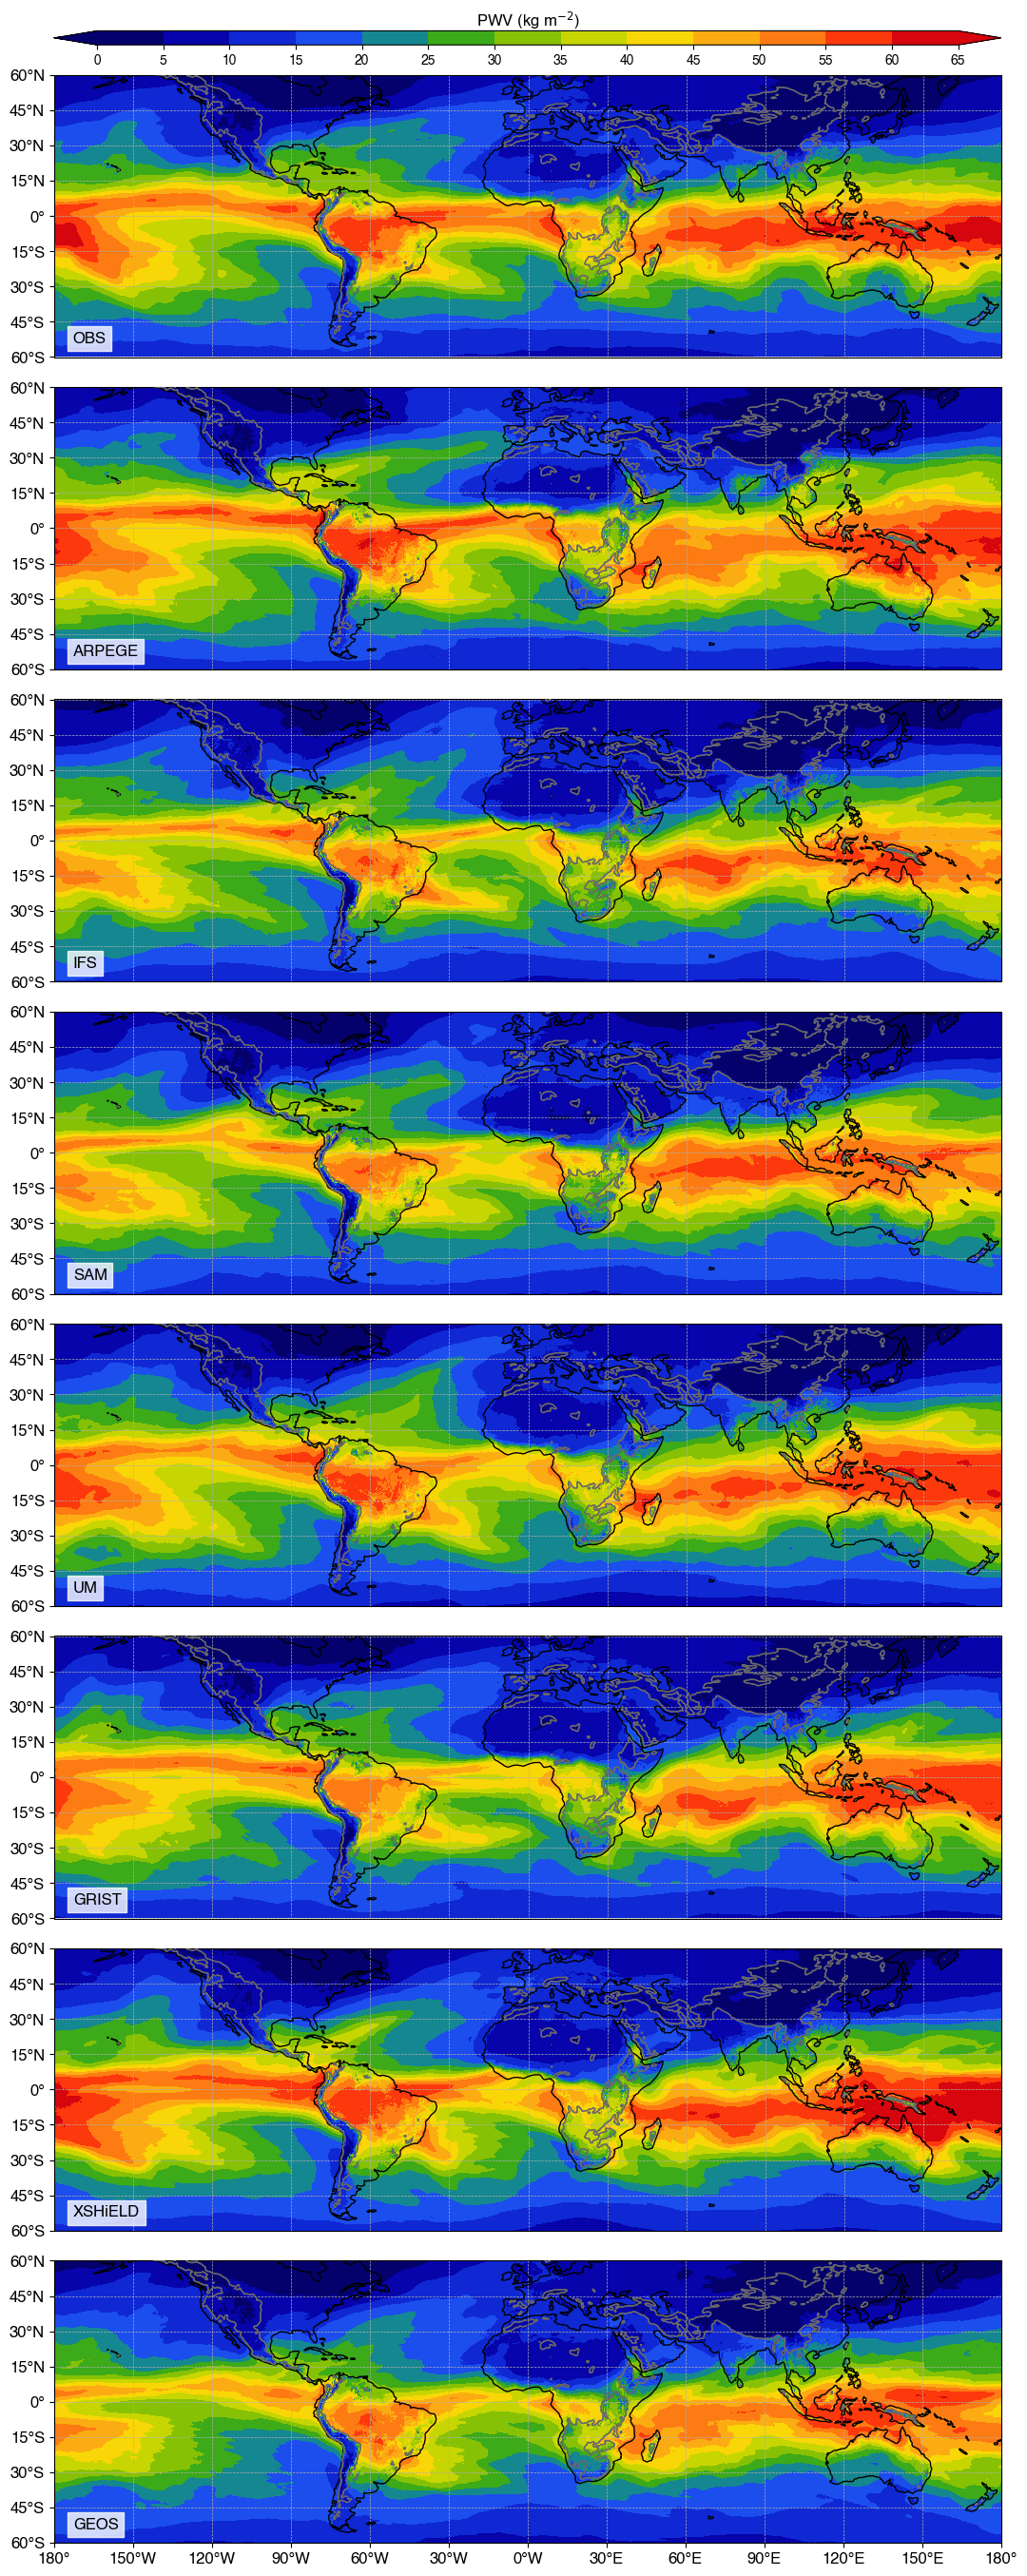

In [17]:
figwidth = 12
height_ratio_per_panel = 0.35
ratio = height_ratio_per_panel * len(name_map)
figsize = [figwidth,figwidth*ratio]
fontsize = 12
cb_fontsize = 10
varname1 = 'PWV'
# varname2 = '$\Delta$MCS Rain'
units = 'kg m$^{-2}$'

# Combine OBS & model DataSet
data_dict = xr.concat([dso_interp.intqv, dsm.intqv], dim='source')
lev1 = np.arange(0, 70, 5)
cmap1 = cc.cm['rainbow4']

nrows = len(name_map)
nmodel = nrows-1
titles = list(name_map.values())

levels = [lev1] * nrows
cbticks = levels
cmaps = [cmap1]* nrows
oob_colors = [None] * nrows
# oob_colors = [{'under':'white', 'over':'firebrick'}] + [None]*nmodel
cblabels = [f'{varname1} ({units})']
text_colors = {'pos':'teal', 'neg':'darkgoldenrod'}

figname = f'{figdir}globalmap_pwv_obs_all.png'

fig = plot_maps_nrow(nrows, data_dict, lon_m, lat_m, titles, levels, cmaps, cblabels, cbticks, figname, 
                     figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, show_cb2=False)
                     # boxes=boxes, boxtextloc=text_loc, dict_text_type=dict_text_type, dict_text_val=dict_text_val, text_colors=text_colors)

In [18]:
name_map

{'obs': 'OBS',
 'm1': 'ARPEGE',
 'm2': 'IFS',
 'm5': 'SAM',
 'm6': 'UM',
 'm7': 'GRIST',
 'm9': 'XSHiELD',
 'm10': 'GEOS'}

In [19]:
# intqv_diff.sel(source='m4').plot(vmin=-20, vmax=20, cmap='BrBG')
# mcspcp_obs_pyflex, mcspcp_mod_pyflex, mcspcp_diff_pyflex = get_obs_model_diff(mcspcp_pyflex)

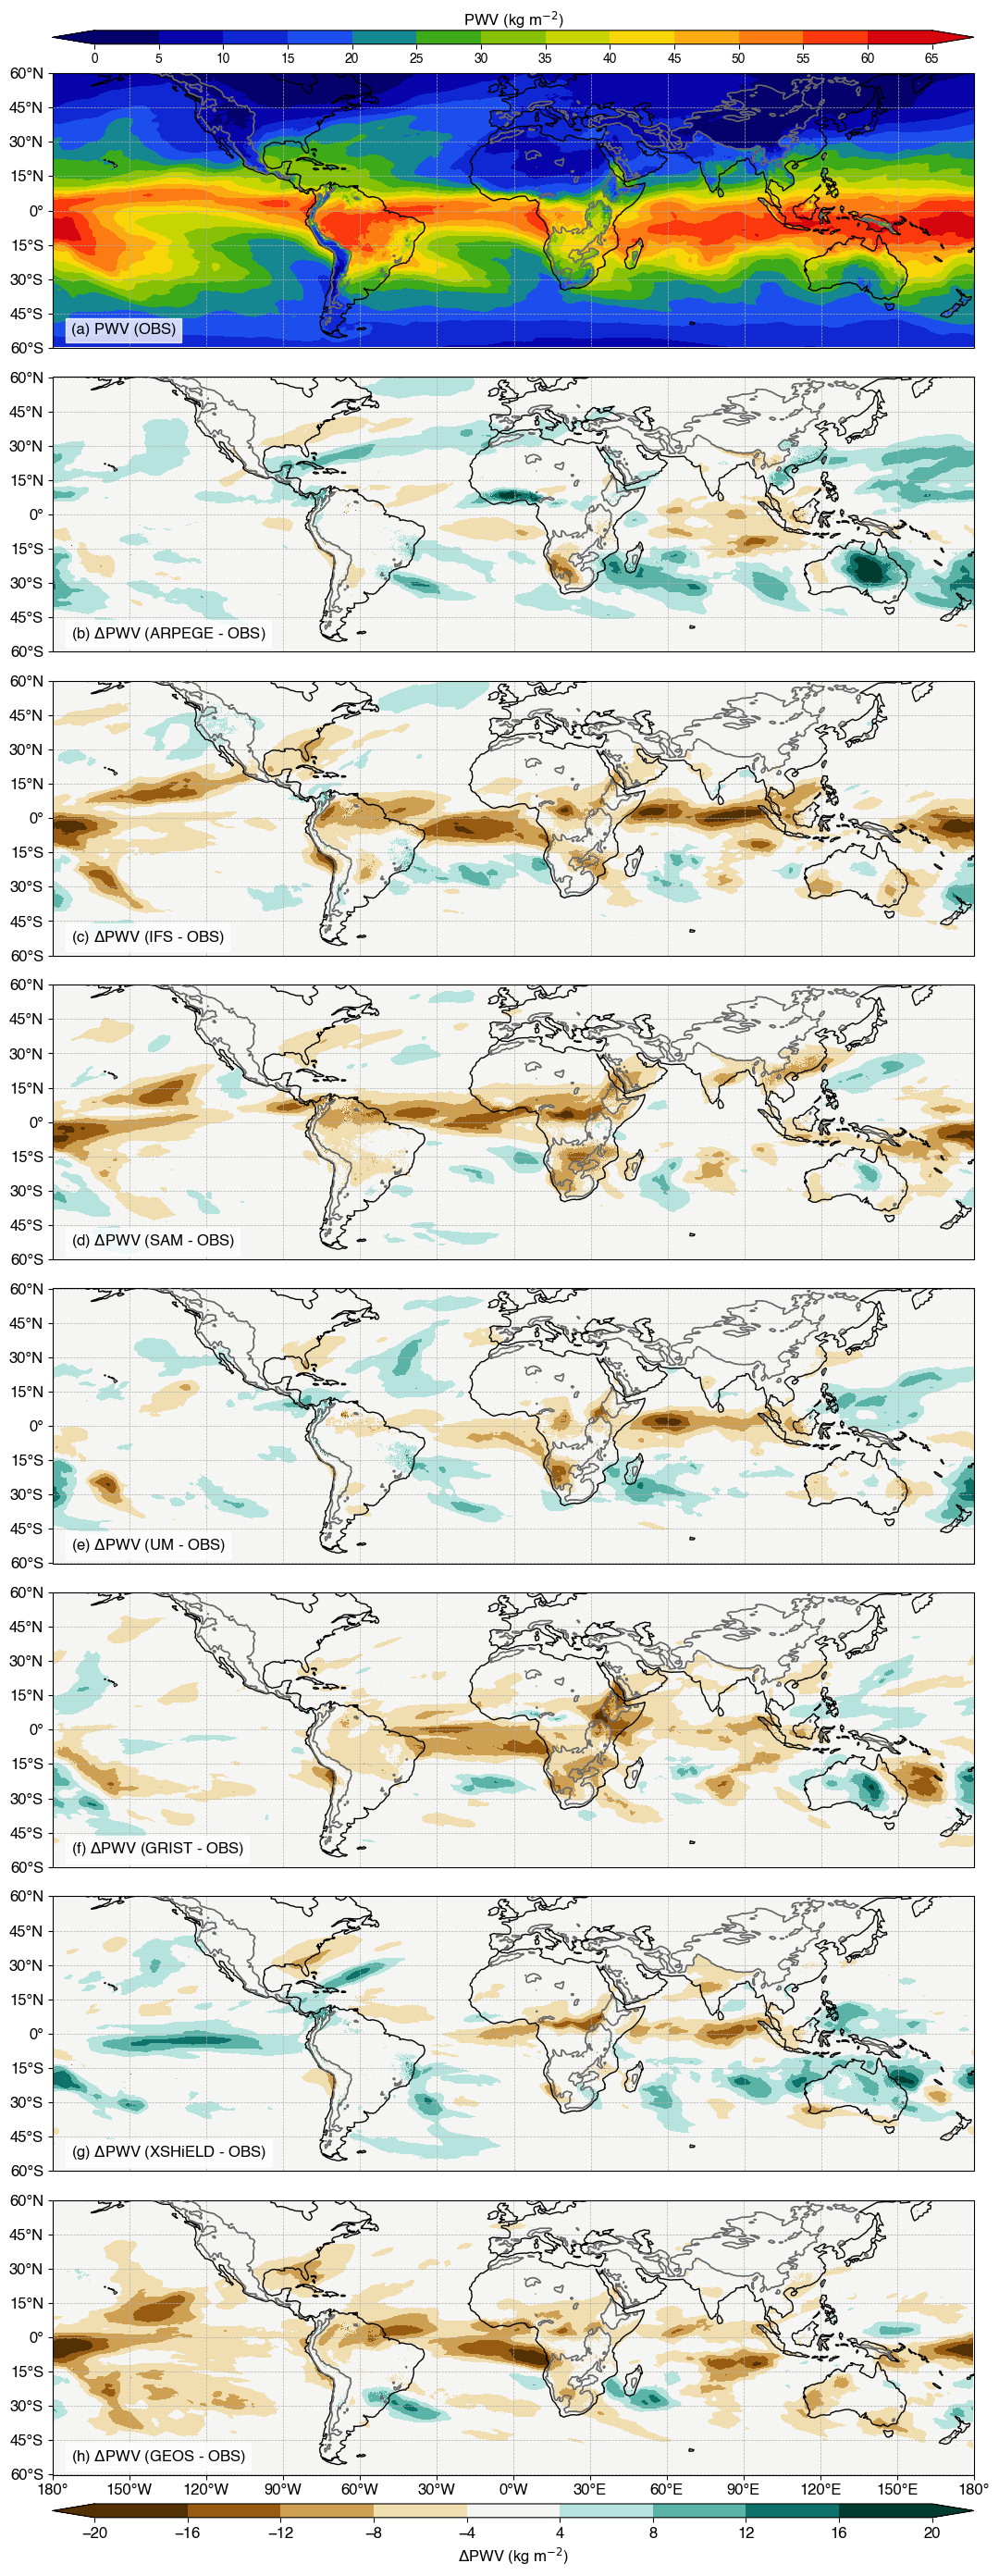

In [20]:
figwidth = 12
height_ratio_per_panel = 0.35
ratio = height_ratio_per_panel * len(name_map)
figsize = [figwidth,figwidth*ratio]
fontsize = 12
cb_fontsize = 10
varname1 = 'PWV'
varname2 = '$\Delta$PWV'
units = 'kg m$^{-2}$'

# Combine OBS & model DataSet
data_dict = xr.concat([dso_interp.intqv, intqv_diff], dim='source')
lev1 = np.arange(0, 70, 5)
lev2 = [-20,-16,-12,-8,-4,4,8,12,16,20]
cmap1 = cc.cm['rainbow4']
cmap2 = 'BrBG'

nrows = len(name_map)
nmodel = nrows-1
# titles = list(name_map.values())
titles = []
for ii in range(len(name_map)):
    key = list(name_map.keys())[ii]
    label = '('+chr(ord('a') + ii)+')'
    if key == 'obs': 
        titles.append(f'{label} {varname1} ({name_map[key]})')
    else:
        titles.append(f'{label} {varname2} ({name_map[key]} - OBS)')

levels = [lev1] + [lev2]*nmodel
cbticks = levels
cmaps = [cmap1] + [cmap2]*nmodel
oob_colors = [None] * nrows
# oob_colors = [{'under':'white', 'over':'firebrick'}] + [None]*nmodel
cblabels = [f'{varname1} ({units})', f'{varname2} ({units})']
text_colors = {'pos':'teal', 'neg':'darkgoldenrod'}

figname = f'{figdir}globalmap_pwv_obs_diff_all.png'

fig = plot_maps_nrow(nrows, data_dict, lon_m, lat_m, titles, levels, cmaps, cblabels, cbticks, figname, 
                     figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, show_cb2=True)
                     # boxes=boxes, boxtextloc=text_loc, dict_text_type=dict_text_type, dict_text_val=dict_text_val, text_colors=text_colors)

In [21]:
figname

'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Winter/figures/MCSMIP/globalmap_pwv_obs_diff_all.png'

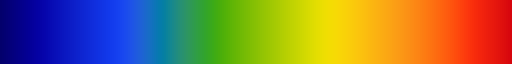

In [22]:
cc.cm['rainbow4']